# 1 Abstract

In this project, I wanted to do multiclass classification on an imbalanced dataset based on the text. This is not the simplest ML problem, since most of the typical statistical models cannot handle the text data (only continuous and categorical). That is why, we usually leave this task for Neural Networks. However, we still have Naive Bayes classifier and SVM classifier. Therefore, I want to compare the performance of ML algorithm (we will choose Naive Bayes because it is usually simpler and faster than SVM classifier) and DL. There is a widespread belief that DL models are more accurate while ML models are faster. So, in the end we will be able to test this hypothesis on the given data

# 2 Dataset



### 2.1 Source

In the previous projects we used to work with csv files. They were downloaded and after that read with the help of pandas. Now we will take dataset directly from Kaggle without downloading it. To do so, we will use Kaggle API (for more details, see references)


### 2.2 Structure

We will take one of the very popular datasets from Kaggle. It represents information about different wines. The thing I want to do is to identify the location of wine given its description. That is why, we will leave just one feature (description) and will use it to predict country. The dataset is an imbalanced one and I also want to show why this is bad and why we need to do some preprocessing (undersampling or oversampling) to resolve the issue. It will be done by comparing the results on the whole dataset and on the undersampled one

### 2.3 Getting the data

Note that you need first to download a special file from Kaggle named kaggle.json, which will be a unique file for anybody. After that, the procedure of getting needed datasets does not change

In [1]:
! pip install -q kaggle

In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:

! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets list

ref                                                  title                                       size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------  -----------------------------------------  -----  -------------------  -------------  ---------  ---------------  
iamsouravbanerjee/house-rent-prediction-dataset      House Rent Prediction Dataset               82KB  2022-08-20 13:49:03           4574        153  1.0              
deepcontractor/mcdonalds-india-menu-nutrition-facts  McDonald's India : Menu Nutrition Dataset    5KB  2022-07-28 17:08:52           4224        165  0.9411765        
arianazmoudeh/airbnbopendata                         Airbnb Open Data                            10MB  2022-08-01 15:58:10           2644         87  0.9705882        
digitalbro/usa-childrens-hospitals                   USA Childrens Hospitals                     18KB  2022-08-24 02:20:09            275         24  1.0       

In [6]:
import pandas as pd
import numpy as np

In [7]:
! kaggle datasets download zynicide/wine-reviews

#downloading a dataset we are interested in

 94% 48.0M/50.9M [00:00<00:00, 102MB/s] 
100% 50.9M/50.9M [00:00<00:00, 76.1MB/s]


In [8]:
! unzip wine-reviews.zip

Archive:  wine-reviews.zip
  inflating: winemag-data-130k-v2.csv  
  inflating: winemag-data-130k-v2.json  
  inflating: winemag-data_first150k.csv  


# 3 Data Preprocessing

In [9]:
df2 = pd.read_csv('winemag-data_first150k.csv')
df2 = df2.iloc[:, 1:]
df2 = df2[['country', 'description']]
df2 = df2.dropna()
df2
print(df2['country'].value_counts())

US                        62397
Italy                     23478
France                    21098
Spain                      8268
Chile                      5816
Argentina                  5631
Portugal                   5322
Australia                  4957
New Zealand                3320
Austria                    3057
Germany                    2452
South Africa               2258
Greece                      884
Israel                      630
Hungary                     231
Canada                      196
Romania                     139
Slovenia                     94
Uruguay                      92
Croatia                      89
Bulgaria                     77
Moldova                      71
Mexico                       63
Turkey                       52
Georgia                      43
Lebanon                      37
Cyprus                       31
Brazil                       25
Macedonia                    16
Serbia                       14
Morocco                      12
England 

### 3.1 As we see, dataset is very imbalanced

I want to show why this is a trouble by comparing the model performance on both imbalanced and undersampled dataset. However, we will work not with all classes. In the context of problem, I do not see any point in considering more than 10 classes, making it more complicated for model to learn and for us to interpret the results. So, we will leave only those classes having at least 3000 observations

In [10]:
res_stats = df2.groupby('country')['country'].agg('count').sort_values(ascending = False)
res_stats
res_stats_less_than_3000 = res_stats[res_stats < 3000]
df2.country = df2.country.apply(lambda x: 'other' if x in res_stats_less_than_3000 else x)
df2 = df2[df2['country'] != 'other']
df2.index = np.arange(0, len(df2))
df2

,country,description
0,US,This tremendous 100% varietal wine hails from ...
1,Spain,"Ripe aromas of fig, blackberry and cassis are ..."
2,US,Mac Watson honors the memory of a wine once ma...
3,US,"This spent 20 months in 30% new French oak, an..."
4,France,"This is the top wine from La Bégude, named aft..."
...,...,...
143339,Italy,Many people feel Fiano represents southern Ita...
143340,France,"Offers an intriguing nose with ginger, lime an..."
143341,Italy,This classic example comes from a cru vineyard...
143342,France,"A perfect salmon shade, with scents of peaches..."


### 3.2 NLP part

We will delete punctuation and stop words, since the presence of these symbols will not make our model perform better. Moreover, it can result in worse performance, overfitting, and more time to train the model

For doing so, we will use NLTK library. This code will take from 10 to 15 minutes, on average, to compile, which is much more than everything else in a Machine Learning section combined. However, I still find this step useful and necessary

In [11]:
import nltk
from nltk import word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
from sklearn.feature_extraction.text import CountVectorizer
def text_cleaning(a):
  remove_punctuation = [char for char in a if char not in string.punctuation]
  remove_punctuation = ''.join(remove_punctuation)
  remove_punctuation = [word for word in remove_punctuation.split() if word.lower() not in stopwords.words('english')]
  return ' '.join(remove_punctuation)

df2['description'] = df2['description'].apply(text_cleaning)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### 4 Machine Learning

### 4.1 Model selection

Initially, I wanted to use both Naive Bayes classifier and SVM classifier. When I was working with them previously, the former one turned out to be much faster but less efficient than the latter one. However, we will implement a very slow yet efficient algorithm in Deep Learning part, so we do not probably need one more slow algorithm. I also do not want to implement SVM classifier, since there are already a lot of interesting and important things in this project

That is why, we will use Naive Bayes only. It is a very simple one. We just memorise typical combinations of words that are suitable for different classes. In the end, we will be able to calculate the conditional probabilities. So, we choose the most likely class given the combinations of words we have. The problem of the algorithm (what actually makes it naive and relatively fast at the same time) is that order does not matter. However, we understand, that it actually matters, since by changing the order of words in a sentence we can change the whole structure and point of the sentence

### 4.2 Metrics

In this problem, I do not care too much about False Positives or False Negatives. If a Spanish wine was considered as not Spanish, it is not a big problem. On the other hand, if not Spanish wine was considered as Spanish, it is also not a big problem. Therefore, the most important metric is Accuracy, since both Precision and Recall are not significant for us in the context of problem. However, we deal with imbalaced dataset, where Accuracy is bad in terms of model evaluation. That is why, we will look at Accuracy, Precision, Recall, and Confusion Matrix. Checking more metrics is always better when we want to compare different models. Balanced dataset can be worse in terms of Accuracy than the imbalanced one. However, the general performance is usually better

### 4.3 Working with imbalanced dataset

We alredy processed our data and got df2. Now we will run our algorithm on this table using standard train-test split approach, calculate all the necessary metrics, and plot the confusion matrix. There is no point in validation since there is actually nothing to tune


Accuracy is :  0.8562210052670132
              precision    recall  f1-score   support

   Argentina       0.70      0.55      0.62      1088
   Australia       0.67      0.68      0.68       977
     Austria       0.89      0.31      0.46       616
       Chile       0.74      0.58      0.65      1141
      France       0.76      0.87      0.81      4219
       Italy       0.95      0.94      0.94      4673
 New Zealand       0.83      0.65      0.73       664
    Portugal       0.96      0.37      0.54      1070
       Spain       0.60      0.89      0.72      1582
          US       0.93      0.96      0.95     12639

    accuracy                           0.86     28669
   macro avg       0.81      0.68      0.71     28669
weighted avg       0.86      0.86      0.85     28669



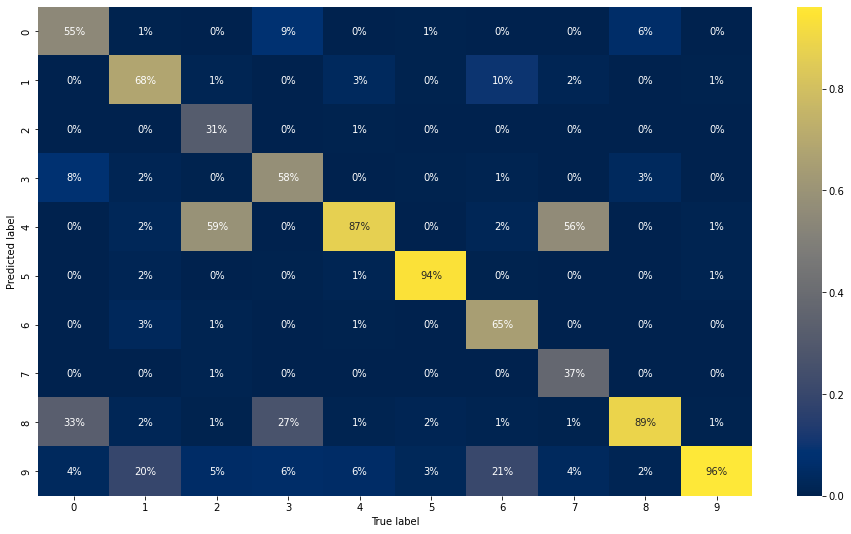

In [12]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df2.description, df2.country, test_size = 0.2)
from sklearn.feature_extraction.text import CountVectorizer
v = CountVectorizer()
x_train_count = v.fit_transform(x_train.values)
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
model.fit(x_train_count,y_train)
x_test_count = v.transform(x_test)
model_predictions = model.predict(x_test_count)
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.gcf().set_size_inches(16, 9)
# accuracy on X_test
accuracy = model.score(x_test_count, y_test)
conf_mat = confusion_matrix(y_test, model_predictions, normalize="true")
# Plot the confusion matrix
sns.heatmap(conf_mat.T, annot=True, fmt=".0%", cmap="cividis")
plt.xlabel("True label")
plt.ylabel("Predicted label")
print('')
print('Accuracy is : ', accuracy)
from sklearn.metrics import classification_report
print(classification_report(y_test, model.predict(x_test_count)))

### 4.4 Results

Despite the Accuracy is high, other metrics are low. The feature of the imbalanced dataset is low Recall for dominated classes since they are often recognized as dominant classes (hence, there are many False Negative examples). Here we see that Recall is relatively high for big classes and relatively low for small classes. Sometimes it is less than 40 percent

In terms of confusion matrix, we see that two classes are more than 50% of the time recognized as something else, which tells me that results are unsatisfying

### 4.5 Why other metrics (not just Accuracy) should be considered ad well?

Accuracy is a very good metric for several reasons. Firstly, it is very intuitively clear. Everyone understands that the percentage of observations that were correctly classified can tell us whether the model is performing good or bad. Secondly, it it simple to interpret. Again, it is intuitively clear that 60% Accuracy is probably not so nice, while 95% seems very good

However, suppose that our Accuracy is 90%. This means that our Accuracy explains perfectly these 90% of observations. On the other hand, we do not know anything about other 10%. Other metrics, such as Precision and Recall, explain this relatively well. By observing their values, we can say, whether the model is consistent or not, and, if not, whether the problem is in False Positives (if Precision is low) or in False Negatives (if Recall is low)

In [13]:
df2

,country,description
0,US,tremendous 100 varietal wine hails Oakville ag...
1,Spain,Ripe aromas fig blackberry cassis softened swe...
2,US,Mac Watson honors memory wine made mother trem...
3,US,spent 20 months 30 new French oak incorporates...
4,France,top wine La Bégude named highest point vineyar...
...,...,...
143339,Italy,Many people feel Fiano represents southern Ita...
143340,France,Offers intriguing nose ginger lime floral elem...
143341,Italy,classic example comes cru vineyard called Terr...
143342,France,perfect salmon shade scents peaches cherries t...


### 4.6 Do the same with balanced dataset (we will use undersampling)

The idea is that we will count the number of records within the rarest class and select this number of observations from all other classes. As a result, if we randomly choose an observation, each class will equally likely correspond to it

In [14]:
from imblearn.under_sampling import RandomUnderSampler
under_sampler = RandomUnderSampler()
df3 = under_sampler.fit_resample(df2, df2['country'])
df4 = df3[0]
df4

,country,description
0,Argentina,Opens earthy muscle nose soon loses focus fres...
1,Argentina,nose exudes popcorn butter spice palate downri...
2,Argentina,touch chunky oily nose part smacks tropical fr...
3,Argentina,Reduction iodine matchstick aromas cloud bouqu...
4,Argentina,Lean mildly green aromas offer minimal fruit t...
...,...,...
30565,US,Volume Zin vineyard warmest part valley grapes...
30566,US,fact variety still ground county says somethin...
30567,US,good sound red wine made five Bordeaux varieti...
30568,US,fine selection vineyards Dineen Red Willow Sti...



Accuracy is :  0.7414131501472031
              precision    recall  f1-score   support

   Argentina       0.62      0.69      0.65       590
   Australia       0.69      0.78      0.73       567
     Austria       0.77      0.77      0.77       643
       Chile       0.66      0.63      0.65       615
      France       0.73      0.46      0.57       624
       Italy       0.96      0.93      0.94       626
 New Zealand       0.76      0.85      0.80       579
    Portugal       0.69      0.79      0.73       628
       Spain       0.65      0.72      0.68       591
          US       0.92      0.80      0.85       651

    accuracy                           0.74      6114
   macro avg       0.74      0.74      0.74      6114
weighted avg       0.75      0.74      0.74      6114



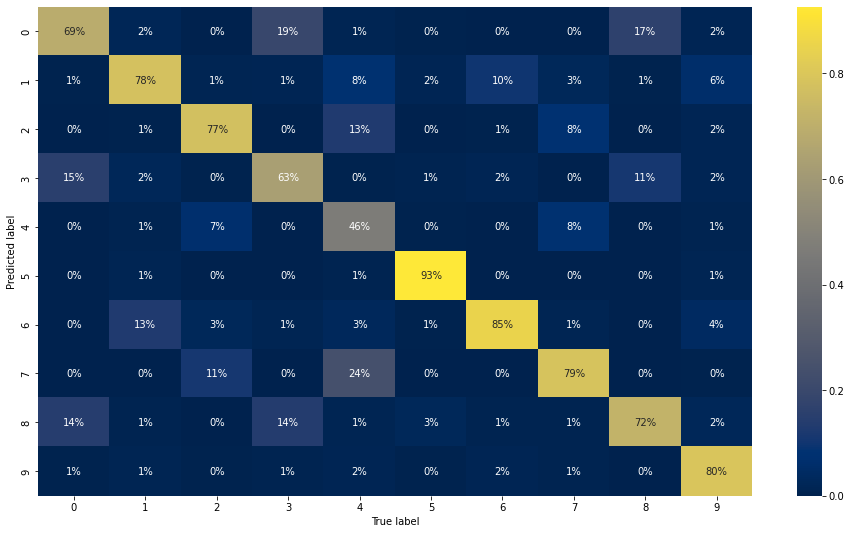

In [15]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df4.description, df4.country, test_size = 0.2)
from sklearn.feature_extraction.text import CountVectorizer
v = CountVectorizer()
x_train_count = v.fit_transform(x_train.values)
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
model.fit(x_train_count,y_train)
x_test_count = v.transform(x_test)
model_predictions = model.predict(x_test_count)
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.gcf().set_size_inches(16, 9)
# accuracy on X_test
accuracy = model.score(x_test_count, y_test)
conf_mat = confusion_matrix(y_test, model_predictions, normalize="true")
# Plot the confusion matrix
sns.heatmap(conf_mat.T, annot=True, fmt=".0%", cmap="cividis")
plt.xlabel("True label")
plt.ylabel("Predicted label")
print('')
print('Accuracy is : ', accuracy)
from sklearn.metrics import classification_report
print(classification_report(y_test, model.predict(x_test_count)))

### 4.7 Model performance on balanced dataset

Accuracy is not lower, but it is equal to Precision and Recall. This means that our model has very low variance. Despite it makes mistakes more frequently than the previous model (higher bias), this model will be less likely to confuse classes with each other. As we see, now only one class is correctly classified less than half of the time

### 4.8 One important thing before we move on

The goal of the model is to maximize Accuracy. That is why if there are dominant classes, model will be very likely to assign those classes to random samples, since this will, on average, result in fewer mistakes. This results in overfitting. In the given case it might work well, but if I give another dataset for testing (say, a balanced version of this, the result will be bad). People might come up with a reasonable question - why inventors of those algorithms allow such ways to improve Accuracy by making the model very inconsistent and overfitted? The answer is simple - the models are built under an assumption of a balanced dataset. That is why (since in many situations datasets turn out to be imbalanced ones) we usually have to solve this problems on our own by either doing undersampling (useful when dataset is large) or oversampling (when dataset is small). The result is both loss in accuracy, and preventing overfitting (in our case, better predictions for dominated classes)

# 5 Deep Learning part

### 5.1 Useful information before we start

In some more standard Machine Learning problems (say, regression or non-text classification) it is often sufficient to use Gradient Boosting techniques like CatBoost or LightGBM. Neural Networks, even though might be more accurate and solve problems in end-to-end manner, require a lot of data to train well (however, most of the time it is not a problem), and much more time to learn. In addition, these algorithms are complicated to explain, interpret (black boxes), and sometimes even understand. That is why I try to avoid using them when it is not necessary

Note that the DL part of the code is actually not mine, I have taken it from an open source (see references) and adapted for our problem (there were some important changes). Non-trivial problems (such as this one) usually require doing some researches, seeing what other people have done so far, comparing their solutions and coming up with the one that you find the best. Most of the time, the solution will require some changes that are to be done by oneself. In particular, the author of the code was using testing set for both test and validation of the data, while I made one more additional set for validation

### 5.2 Why Deep Learning is applicable to this problem?

Most of Machine Learning algorithms cannot handle text data. As far as I am aware, most typically used algorithms are Naive Bayes and SVM classifier (for text classification). The drawbacks of the Naive Bayes I have already explained, while Support Vector Machine is a very general algorithm which might be used to solve probably any type of Supervised ML problems. That is why, I want to try something more specific. Neural Networks are mentioned to work exceptionally well in terms of text classification, since there are specific and unique algorithms designed for it. Additionally, now we will be able to introduce weights to our classes. In other words, we will handle imbalanced dataset problem without reducing the number of observations

### 5.3 Plan

I will try to do my best at explaining what we are doing here. In the case of Machine Learning algorithm everything is simple and standard, hence, I do not spend much time explaining the code. In case of Neural Networks I will. After that, we will do a comparison of these model with ML part and come up with conclusions

### 5.4 Model construction

###### 5.4.1 Weights

In [44]:
from sklearn.utils import class_weight
class_weights = list(class_weight.compute_class_weight(class_weight = 'balanced', 
                                                       classes = np.unique(df2['country']), 
                                                       y = df2['country']))

In [45]:
df2['country'].value_counts()

US             62397
Italy          23478
France         21098
Spain           8268
Chile           5816
Argentina       5631
Portugal        5322
Australia       4957
New Zealand     3320
Austria         3057
Name: country, dtype: int64

In [46]:
class_weights.sort()
class_weights

[0.22972899338109204,
 0.6105460431041826,
 0.67941985022277,
 1.7337203676826318,
 2.4646492434662997,
 2.545622447167466,
 2.693423524990605,
 2.8917490417591285,
 4.317590361445784,
 4.689041543997383]

As we see, the smaller the class is, the higher its weight is. Because of that, the model will not be able to increase accuracy by recognizing the dominant classes too often, since it will be penalized for misclassifying the minority samples

In [47]:
weights = {}
for index, weight in enumerate(class_weights):
  weights[index] = weight

###### 5.4.2 Sets

In terms of Machine Learning problems, I do not usually see the point in making 3 sets. To my mind, K-Fold Cross Validation is a reasonable substitution for validation set, since we have more metrics, every observation is used for both training and testing the data, and it is done in a simplier and more convenient way. However, in Deep Learning problems we are usually required to have a validation set, so we will split our data into 3 sets. This will be done by separating the training data from the other data in the first step, and by spliting the remaining data to validation and testing sets

In [48]:
x_train, x_rem, y_train, y_rem = train_test_split(df2.description,df2.country, train_size=0.8)
x_valid, x_test, y_valid, y_test = train_test_split(x_rem,y_rem, test_size=0.5)
import tensorflow as tf
import tensorflow_hub as hub

In [49]:
dataset_train = tf.data.Dataset.from_tensor_slices((x_train.values, y_train.values))
dataset_test = tf.data.Dataset.from_tensor_slices((x_test.values, y_test.values))
dataset_valid = tf.data.Dataset.from_tensor_slices((x_valid.values, y_valid.values))

###### 5.4.3 Convert target column to numbers

We will use Tensforlow's built-in hashtable for doing so. Note that we put classes in a special order (in a way that weights are ascending)

In [50]:



table = tf.lookup.StaticHashTable(
    initializer = tf.lookup.KeyValueTensorInitializer(
        keys = tf.constant(['US', 'Italy', 'France', 'Spain', 'Chile', 'Argentina', 'Portugal', 'Australia', 'New Zealand', 'Austria']),
        values = tf.constant([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
    ),
    default_value = tf.constant(-1),
    name = 'target_encoding'
)

def target(x):
  return table.lookup(x)

###### 5.4.4 Visual representation of the data

In [51]:
def show_batch(dataset, size=5):
  for batch, label in dataset.take(size):
    print(batch.numpy())
    print(target(label).numpy())

show_batch(dataset_test, 10)


b'mildly floral nose leads lean acidic palate flavors lemon green apple'
3
b'Norace blend Cannonau Syrah Carignano offers dried fruit spice backed tobacco black olive whiff blue flower mouthfeel dominated savory flavors peppercorn cured meat'
1
b'Overoaked hot sour raspberry fruit Plain simple wine way much wood tannin fire price outlandish'
4
b'Fragrant floral tones drying mineral notes characterize luminous Prosecco Brut sparkling wine delivers frothy peach herbal accents steady dose citrus zest'
1
b'surprisingly good show soggy vintage ripe bordering stewy rich notes prune blueberry mushroom forest floor tannins hard theres plenty toast spice finish 6020155 percent SangioveseCabernet SauvignonMerlotSyrah blend'
1
b'Stiff hard green leafy flavors tough tight tannins type Oregon Pinot needs breathing time decanting perhaps years cellar'
0
b'Immaculately clean ripe fruit display potpourri mixed berries High toned aromas bring accents wildflowers honey vanilla continuing pretty finish'


###### 5.4.5 Encoding (convert string values to numeric ones)

In [52]:
def fetch(text, labels):
  return text, tf.one_hot(target(labels), 10)


In [53]:
train_data_f = dataset_train.map(fetch)
test_data_f = dataset_test.map(fetch) 
valid_data_f = dataset_valid.map(fetch) 

In [54]:
train_data, train_labels = next(iter(train_data_f.batch(9)))
train_data, train_labels

(<tf.Tensor: shape=(9,), dtype=string, numpy=
 array([b'taut nervy wine tight structure acidity crisp dry taste offering intense green apple lemon zest wine even better 2\xe2\x80\x933 years',
        b'bit soft sweet Zinfandel sure delicious berry fruit chocolate pepper herb flavors Drink barbecue',
        b'Intital bright green fruit aromas concentrated intense style wine smoky flavors complement crisp green freshness complete wine well balanced fruits place along spice',
        b'good Cab little young need cellaring fruit drink plush black currant cr\xc3\xa8me de cassis new oaky flavors wrapped soft velvety tannins chocolaty licorice finish hold good ten years',
        b'8789 Barrel sample Quite light wine fresh style attractive fruits tannins showing along bright acidity',
        b'Sour cherry damp soil wet rocks frame minerallyminded Pinot Noir coastal range northern part county palate dominated herbs oregano thyme fennel licorice ripe cranberry framing fruit profile intriguing

###### 5.4.6 Applying pretrained Tensorflow model

In [55]:
embedding = 'https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1'
hub_layer = hub.KerasLayer(embedding, output_shape=[128], input_shape=[], dtype=tf.string, trainable=True)
hub_layer(train_data[:1])


<tf.Tensor: shape=(1, 128), dtype=float32, numpy=
array([[ 0.05772785, -0.3424155 ,  0.18887639, -0.04631041, -0.0282944 ,
        -0.00843976,  0.12190825,  0.11346994,  0.04339409,  0.20060194,
        -0.09115889, -0.0474581 , -0.20091057,  0.14726013, -0.02516664,
        -0.12226307,  0.01243885,  0.1682637 ,  0.02708486, -0.04420022,
         0.09762587, -0.0746639 , -0.1658398 , -0.09940553,  0.02810469,
        -0.10940417,  0.36570385, -0.18902   , -0.01863232, -0.327137  ,
        -0.09375865, -0.03590075, -0.0833379 ,  0.43534687,  0.3426385 ,
        -0.0318408 ,  0.0194397 , -0.1806073 , -0.09568553,  0.21803218,
        -0.22520173, -0.06746688, -0.08736845,  0.12254096, -0.03746471,
         0.069362  , -0.10251056,  0.3050877 ,  0.4027132 ,  0.17300604,
         0.12856632, -0.24645443,  0.01051114,  0.17445324, -0.222384  ,
        -0.03633695,  0.15713358, -0.30118525, -0.18015572,  0.04548446,
         0.09137334,  0.0122723 ,  0.30253798, -0.11307118, -0.14302495,
 

###### 5.4.7 Adding layers to the model

In [56]:
model = tf.keras.Sequential()
model.add(hub_layer)
for units in [128, 128, 64, 32]:
  model.add(tf.keras.layers.Dense(units, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(10, activation='softmax')) #output layer
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 128)               124642688 
                                                                 
 dense_5 (Dense)             (None, 128)               16512     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               16512     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dropout_6 (Dropout)         (None, 64)               

###### 5.4.8 Optimizing Network

In [57]:
model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

###### 5.4.9 Create batches for training, validation, and testing

In [58]:
train_data_f = train_data_f.shuffle(114675).batch(512)
valid_data_f = valid_data_f.batch(512)
test_data_f = test_data_f.batch(512)

In [59]:
history = model.fit(train_data_f, epochs=4, validation_data=valid_data_f, verbose=1, class_weight=weights)



Epoch 1/4
224/224 [==============================] - 296s 1s/step - loss: 1.6086 - accuracy: 0.4079 - val_loss: 0.7631 - val_accuracy: 0.6646
Epoch 2/4
224/224 [==============================] - 292s 1s/step - loss: 0.9269 - accuracy: 0.6933 - val_loss: 0.6193 - val_accuracy: 0.7642
Epoch 3/4
224/224 [==============================] - 299s 1s/step - loss: 0.7063 - accuracy: 0.7790 - val_loss: 0.4951 - val_accuracy: 0.8182
Epoch 4/4
224/224 [==============================] - 296s 1s/step - loss: 0.5523 - accuracy: 0.8394 - val_loss: 0.4613 - val_accuracy: 0.8464


###### 5.4.10 Model is done

### 5.5 Why exactly 4 epochs?

Actually, when the last epoch was being done, Accuracy was increasing in a very small rate, and Loss was decreasing in a very small rate. That is why, I was afraid that the model started to explore the noise in order to increase Accuracy in a way we do not want (overfitting). However, model evaluation (by considering important metrics) showed us that the model was not overfitted. Because the rate of improvement was very slow in the end, I decided that there is no point in doing more epochs. We are not likely to get significant improvements, but we are likely to increase variance

In [60]:
len(dataset_train)

114675

In [61]:
len(dataset_test)

14335

In [62]:
len(dataset_valid)

14334

### 5.6 Testing the model, getting the results and metrics

In [63]:

results = model.evaluate(dataset_test.map(fetch).batch(14335), verbose = 2)
print(results)

1/1 - 1s - loss: 0.4623 - accuracy: 0.8476 - 1s/epoch - 1s/step
[0.462345689535141, 0.847575843334198]


In [64]:
test_data, test_labels = next(iter(dataset_test.map(fetch).batch(57340)))

In [65]:
y_pred = model.predict(test_data)
print(classification_report(test_labels.numpy().argmax(axis=1), y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.98      0.93      0.95      6209
           1       0.96      0.96      0.96      2334
           2       0.85      0.66      0.75      2056
           3       0.82      0.62      0.70       877
           4       0.57      0.72      0.64       589
           5       0.58      0.70      0.64       569
           6       0.54      0.77      0.64       554
           7       0.64      0.84      0.73       482
           8       0.70      0.88      0.78       350
           9       0.50      0.84      0.62       315

    accuracy                           0.85     14335
   macro avg       0.71      0.79      0.74     14335
weighted avg       0.87      0.85      0.85     14335



In [71]:
confus_matr = confusion_matrix(test_labels.numpy().argmax(axis=1), y_pred.argmax(axis=1), normalize="true")
confus_matr

array([[9.30101466e-01, 9.01916573e-03, 1.64277661e-02, 2.41584796e-03,
        6.12014817e-03, 3.06007409e-03, 3.70430021e-03, 1.99710098e-02,
        6.60331776e-03, 2.57690449e-03],
       [1.28534704e-02, 9.59725793e-01, 2.14224507e-03, 5.14138817e-03,
        4.71293916e-03, 5.56983719e-03, 8.56898029e-04, 4.28449015e-03,
        3.42759212e-03, 1.28534704e-03],
       [2.67509728e-02, 2.91828794e-03, 6.62937743e-01, 1.45914397e-03,
        5.35019455e-03, 1.45914397e-03, 1.55155642e-01, 2.38326848e-02,
        1.60505837e-02, 1.04085603e-01],
       [6.84150513e-03, 7.98175599e-03, 2.28050171e-03, 6.15735462e-01,
        1.76738883e-01, 1.85860889e-01, 1.14025086e-03, 2.28050171e-03,
        0.00000000e+00, 1.14025086e-03],
       [2.88624788e-02, 5.09337861e-03, 5.09337861e-03, 6.96095076e-02,
        7.24957555e-01, 1.40916808e-01, 3.39558574e-03, 1.35823430e-02,
        8.48896435e-03, 0.00000000e+00],
       [7.02987698e-03, 5.27240773e-03, 3.51493849e-03, 8.61159930e-02,
   

Text(123.0, 0.5, 'Predicted label')

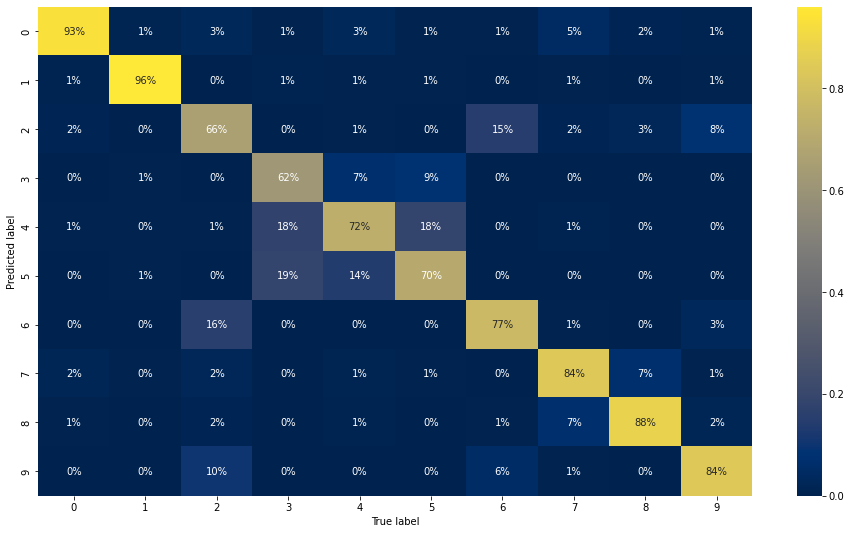

In [72]:
plt.gcf().set_size_inches(16, 9)
sns.heatmap(confus_matr.T, annot=True, fmt=".0%", cmap="cividis")
plt.xlabel("True label")
plt.ylabel("Predicted label")

### 5.7 Interpretation of the results

Both Precision and Recall are never less than 50% and in the majority of the cases Recall is greater than Accuracy. This means, our model is not overfitted. On the other hand, the Accuracy is around 0.85, which means that it has relatively low bias. So, generally the model does well in predicting classes. By looking at the Confusion Matrix, we see that each class is recognized at least 62% of the time, and I do not see cases where some 2 classes are very often confused with each other (slightly less than 20% of the time at maximum). That is why I am very satisfied with the model performance, despite it is (as probably every DL algorithm) very slow and costly to train

# 6 Comparison of the models and their results

### 6.1 The question I want to answer

I have not even started the timer since Neural Network is very very slower than Naive Bayes algorithm (which turned out to be very very fast). In Data Science projects we usually face a problem that I call time-accuracy tradeoff. On the one hand, we have a very clear, interpretable, fast, and easy to code simple algorithm. On the other hand, we can increase accuracy (or any desired metric) by spending much more time in choosing algorithm, coding and training the model

From the results it is clear, that Naive Bayes represents the first situation, while Deep Learning - the second one. So, the point is to verify whether the step towards Neural Networks was reasonable or not in the context of the problem

### 6.2 Naive Bayes vs Neural Network

Note that I will use the results obrained by training the model on the balanced dataset (speaking about ML part)

As I already mentioned, in terms of time Naive Bayes is an absolute winner (there even was no need to put the timer on). However, the model turned out to be worse than DL method by around 10% in each metric (we compare by weighted average, since in Naive Bayes case it is the same as macro one, and in Deep Learning part weighted average is more important). Comparison of confusion matrices tells us that in case of Neural Networks we do better, on average. What is more, we never get diagonal values less than 50% (in Naive Bayes there was such problem ones). Finally, for several reasons I find that both of these models turned out to have low variance. In the context of this problem, I find the improvement we made as a significant one (especially since we have a relatively large dataset, so these results are worth being trusted), therefore, it was worth inversting additional amount of time to construct a complicated model. The only problem is that is it much harder to interpret what was actually done to get the obtained results

# 7 Conclusion

When it comes to some types of Machine Learning problems, at first we usually come up with simple and intuitive solutions. However, sometimes they give us not best possible results (or even unsatisfying ones), so we start thinking about more advanced and sophisticated tools to improve our Accuracy (or whatever metric we are considering). In this project I tried to show, why we sometimes switch to the class of Deep Learning algorithms, as well as explain why imbalanced dataset is a problem and how we can fix this problem

# 8 References

https://www.youtube.com/watch?v=57N1g8k2Hwc - how to work with Kaggle dataset without downloading it using API

https://www.youtube.com/watch?v=dkpS2g4K08s - how to use Deep Learning to solve text multiclass classification problems 